In [11]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau

from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

In [12]:

# empty list to hold feature vectors and train labels
train_features = []
train_labels = []
train_dir = "./dataset/plants/train/*"
test_dir = "./dataset/plants/test/*"
for directory_path in glob.glob(train_dir):
  print(directory_path)
print(test_dir)


./dataset/plants/train\Tomato___Early_blight
./dataset/plants/train\Tomato___Late_blight
./dataset/plants/train\Tomato___Tomato_Yellow_Leaf_Curl_Virus
./dataset/plants/test/*


In [13]:
SIZE = 140
BATCH_SIZE = 64
TARGET_SIZE = (SIZE,SIZE)
EPOCH_NUM = 35

In [14]:
categories_dict = {  
  1: "Tomato___Late_blight",
  0:"Tomato___Early_blight",
  2:"Tomato___Tomato_Yellow_Leaf_Curl_Virus"
}

Data Loading

In [15]:
train_images = []
train_labels = []
label = 0

#Importing the first training dataset

for directory_path in glob.glob(train_dir):

    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        if(counter%200==0): print(counter,"images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        train_images.append(img)
        train_labels.append(label)
        counter+=1
        if(counter%1500==0): break

    print(counter,"images loaded")
    label +=1


x_train = np.array(train_images)
y_train = to_categorical(train_labels, 3)

Tomato___Early_blight
200 images loaded
400 images loaded
541 images loaded
Tomato___Late_blight
200 images loaded
400 images loaded
600

 images loaded
631 images loaded
Tomato___Tomato_Yellow_Leaf_Curl_Virus
200 images loaded
400 images loaded
600 images loaded
647 images loaded


In [16]:
test_images = []
test_labels = []
label = 0

#importing the testing dataset

for directory_path in glob.glob(test_dir):
    assert categories_dict[label] == os.path.normpath(directory_path).split(os.path.sep)[-1]
    print(categories_dict[label])
    counter = 1
    for img_path in glob.glob(os.path.join(directory_path, "*.JPG")):
        if(counter%100==0): print(counter, "images loaded")
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, TARGET_SIZE)
        test_images.append(img)
        test_labels.append(label)
        counter+=1

    print(counter,"images loaded")
    label +=1

test_images = np.array(test_images)
test_labels = to_categorical(test_labels, 3)

Tomato___Early_blight
100 images loaded


193 images loaded
Tomato___Late_blight
100 images loaded
139 images loaded
Tomato___Tomato_Yellow_Leaf_Curl_Virus
100 images loaded
135 images loaded


In [17]:
train_test_split(train_images, train_labels)
train_images, val_images, train_labels, val_labels = train_test_split(x_train, y_train, test_size=0.15, random_state=69)


In [18]:
print("train:",train_images.shape[0],", test:",test_images.shape[0],", val:",val_images.shape[0])

train: 1543 , test: 464 , val: 273


# "Traditional" Feature Extraction with GLCM

In [19]:
def feature_extractor(images):
    image_dataset = pd.DataFrame()
    for image in images:
        df = pd.DataFrame()

        #greycomatrix(image, distances, angles, levels=256, symmetric=False, normed=False)
        #distances - List of pixel pair distance offsets.
        #angles - List of pixel pair angles in radians.

        #5 configuration for the grey-level co-occurrence matrix calculation
        dists = [[1],[3],[5],[3],[3]]
        angles = [[0],[0],[0],[np.pi/4],[np.pi/2]]

        for n ,(dist, angle) in enumerate(zip(dists, angles)):

            GLCM = graycomatrix(image, dist, angle)
            GLCM_Energy = graycoprops(GLCM, 'energy')[0]
            df['Energy'+str(n)] = GLCM_Energy
            GLCM_corr = graycoprops(GLCM, 'correlation')[0]
            df['Corr'+str(n)] = GLCM_corr
            GLCM_diss = graycoprops(GLCM, 'dissimilarity')[0]
            df['Diss_sim'+str(n)] = GLCM_diss
            GLCM_hom = graycoprops(GLCM, 'homogeneity')[0]
            df['Homogen'+str(n)] = GLCM_hom
            GLCM_contr = graycoprops(GLCM, 'contrast')[0]
            df['Contrast'+str(n)] = GLCM_contr

        image_dataset = pd.concat([image_dataset, df])

    return image_dataset


In [20]:
train_extr_features = feature_extractor(train_images)

In [21]:
test_extr_features = feature_extractor(test_images)

In [22]:
val_extr_features = feature_extractor(val_images)

In [23]:
type(train_images)
# convert from integers to floats
train_images_norm = train_images.astype('float32')
test_images_norm = test_images.astype('float32')
val_images_norm = val_images.astype('float32')
# normalize to the range 0-1
train_images_norm /= 255.0
test_images_norm /= 255.0
val_images_norm /= 255.0

In [24]:
pd.set_option("display.max_columns", None)
train_extr_features

,Energy0,Corr0,Diss_sim0,Homogen0,Contrast0,Energy1,Corr1,Diss_sim1,Homogen1,Contrast1,Energy2,Corr2,Diss_sim2,Homogen2,Contrast2,Energy3,Corr3,Diss_sim3,Homogen3,Contrast3,Energy4,Corr4,Diss_sim4,Homogen4,Contrast4
0,0.016852,0.915455,12.606578,0.108112,345.168448,0.015506,0.814045,18.648019,0.080700,759.139677,0.014995,0.732596,22.561005,0.071451,1091.466508,0.015534,0.832639,17.582021,0.082587,685.267486,0.015376,0.821979,18.262304,0.080573,730.306621
0,0.018438,0.947339,8.672867,0.139263,161.483248,0.016289,0.875272,13.235141,0.098669,383.600209,0.015571,0.826705,15.739947,0.089845,535.024392,0.016405,0.884367,12.587324,0.102330,355.714818,0.016499,0.876059,12.801564,0.103883,381.145985
0,0.033463,0.946913,4.506115,0.280520,54.720401,0.024940,0.739351,9.792440,0.163267,270.203702,0.022697,0.543338,13.301640,0.131280,476.325767,0.023374,0.707911,10.686305,0.140777,303.971225,0.022846,0.672530,11.386184,0.136726,340.504432
0,0.012909,0.928943,13.679137,0.087924,394.534224,0.011857,0.858451,18.533629,0.064705,790.099739,0.011463,0.800101,21.873968,0.058586,1122.342011,0.011648,0.828310,20.001260,0.064647,957.566163,0.011696,0.841265,19.391762,0.063867,881.593639
0,0.035074,0.919048,4.288386,0.286218,50.909250,0.029300,0.830034,6.332169,0.199369,107.061783,0.028139,0.787545,7.186878,0.182491,134.296190,0.028861,0.829442,6.483617,0.190280,108.035392,0.028488,0.842051,6.448905,0.188370,100.384567
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.019239,0.969813,6.634173,0.185059,105.800462,0.016076,0.897964,11.664129,0.120819,356.553285,0.015051,0.828016,15.148995,0.105416,598.730053,0.015585,0.873370,13.012602,0.112317,441.913359,0.015672,0.861479,13.353910,0.114325,485.239625
0,0.016187,0.935513,11.447122,0.099863,262.951233,0.014929,0.850367,16.796976,0.078076,609.852138,0.014247,0.779233,20.345714,0.066787,898.632169,0.014528,0.812188,19.092733,0.067279,763.392985,0.014552,0.780567,20.460897,0.066617,890.199062
0,0.025581,0.887381,6.448561,0.173251,87.322251,0.021431,0.723663,10.121116,0.115139,215.984619,0.020329,0.641899,11.828201,0.102400,282.031164,0.021419,0.715698,10.268851,0.117162,220.911363,0.021806,0.770787,9.502294,0.118549,176.742023
0,0.030623,0.955193,4.902980,0.223078,59.123638,0.023975,0.782889,10.303597,0.133780,289.306517,0.022596,0.621762,13.573598,0.118102,509.070741,0.023241,0.775446,10.659840,0.124782,301.037912,0.022717,0.724165,11.864494,0.117113,368.136757


# Building the Network

In [25]:
from keras.layers import Dropout
from keras.optimizers import SGD, RMSprop
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

**Convolutional Neural Network to extract the high-level features**

In [26]:
def build_cnn():
    model = keras.Sequential([
        keras.Input(shape=(140,140,1), name='Original_Images'),
        keras.layers.Conv2D(input_shape=(140,140,1), filters=32, kernel_size=11,
                            strides=1, activation='relu', name='Conv1'),
        keras.layers.BatchNormalization(),

        keras.layers.Conv2D(input_shape=(130,130,32), filters=32, kernel_size=11,
                            strides=1, activation='relu', name='Conv2'),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),
        keras.layers.Dropout(0.2),
        
        keras.layers.Conv2D(input_shape=(58,58,32), filters=64, kernel_size=9,
                            strides=1, activation='relu', name='Conv3'),
        keras.layers.BatchNormalization(),
        
        keras.layers.MaxPool2D(pool_size=(5, 5), strides=2),        
        keras.layers.Conv2D(input_shape=(23,23,64), filters=128, kernel_size=8,
                            strides=1, activation='relu', name='Conv4'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),
        
        keras.layers.Conv2D(input_shape=(16,16,128), filters=256, kernel_size=9,
                            strides=1, activation='relu', name='Conv5'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.3),

        keras.layers.Conv2D(input_shape=(8,8,256), filters=256, kernel_size=8,
                            strides=1, activation='relu', name='Conv6'),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.4),

        keras.layers.Flatten(),
        keras.layers.BatchNormalization(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense')
    ])
    print(model.summary())
    return model

**Multilayer Perceptron to learn the numerical feature data extracted from the GLCM**

In [27]:
def build_mlp():
    model = keras.Sequential([
        keras.Input(shape=25, name='Extracted_Traditional_Features'),
        keras.layers.Dense(8, activation=tf.keras.activations.relu, name='Dense1'),
        keras.layers.Dense(4, activation=tf.keras.activations.relu, name='Dense2')
    ])
    print(model.summary())
    return model

**Intertwining the 2 feature extractor**

In [28]:
mlp = build_mlp()
cnn = build_cnn()

combinedInput = concatenate([mlp.output, cnn.output])

x = Dense(8, activation="relu")(combinedInput)
x = Dense(3, activation="softmax")(x)

model = Model(inputs=[mlp.input, cnn.input], outputs=x)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Dense1 (Dense)              (None, 8)                 208       
                                                                 
 Dense2 (Dense)              (None, 4)                 36        
                                                                 
Total params: 244 (976.00 Byte)
Trainable params: 244 (976.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 130, 130, 32)      3904      
                                                                 
 batch_normalization (Batch  (None, 130, 130, 32)      128       
 Normalization)                                                  
                                                                 
 Conv2 (Conv2D)              (None, 120, 120, 32)      123936    
                                                                 
 batch_normalization_1 (Bat  (None, 120, 120, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 58, 58, 32)        0         
 D)                                                              
                                                      

In [29]:
opt = keras.optimizers.Adam(learning_rate=0.005)

In [30]:
model.compile(optimizer=opt, loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=[keras.metrics.CategoricalAccuracy()])

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [31]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

cb = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=10,
        mode='auto',
        min_delta=0.0002,
        cooldown=5,
        min_lr=10e-8,
        verbose=1,
    )
]

# Learning

In [32]:
dataset_inputs = tf.data.Dataset.from_tensor_slices((train_extr_features, tf.expand_dims(train_images_norm, axis=-1)))
dataset_label = tf.data.Dataset.from_tensor_slices(train_labels)

dataset = tf.data.Dataset.zip((dataset_inputs, dataset_label)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TRAIN= train_images_norm.shape[0]//BATCH_SIZE
# fit model
history = model.fit(dataset,
                    validation_data=([val_extr_features, tf.expand_dims(val_images_norm, axis=-1)], val_labels),
                    epochs = EPOCH_NUM, steps_per_epoch=STEP_SIZE_TRAIN, callbacks=cb)



Epoch 1/35


c:\Users\luppe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - ETA: 0s - loss: 3.5463 - categorical_accuracy: 0.4167 

c:\Users\luppe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\backend.py:5577: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


24/24 [==============================] - 369s 15s/step - loss: 3.5463 - categorical_accuracy: 0.4167 - val_loss: 1754.9412 - val_categorical_accuracy: 0.3333 - lr: 0.0050
Epoch 2/35
24/24 [==============================] - 358s 15s/step - loss: 1.1377 - categorical_accuracy: 0.4341 - val_loss: 60.7667 - val_categorical_accuracy: 0.3333 - lr: 0.0050
Epoch 3/35
24/24 [==============================] - 357s 15s/step - loss: 0.9949 - categorical_accuracy: 0.5112 - val_loss: 11.4820 - val_categorical_accuracy: 0.3626 - lr: 0.0050
Epoch 4/35
24/24 [==============================] - 359s 15s/step - loss: 0.9521 - categorical_accuracy: 0.5680 - val_loss: 2.4877 - val_categorical_accuracy: 0.4249 - lr: 0.0050
Epoch 5/35
24/24 [==============================] - 358s 15s/step - loss: 0.8989 - categorical_accuracy: 0.5977 - val_loss: 1.8839 - val_categorical_accuracy: 0.4322 - lr: 0.0050
Epoch 6/35
24/24 [==============================] - 358s 15s/step - loss: 0.8424 - categorical_accuracy: 0.6254

# Testing

In [33]:
test_inputs = tf.data.Dataset.from_tensor_slices((test_extr_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labelz = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labelz)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model.evaluate(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

7/7 [==============================] - 31s 4s/step - loss: 0.4405 - categorical_accuracy: 0.8438
Test loss: 0.44048118591308594 / Test accuracy: 0.84375


# Plotting the metrics

In [34]:
import matplotlib.pyplot as plt
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy', 'lr'])

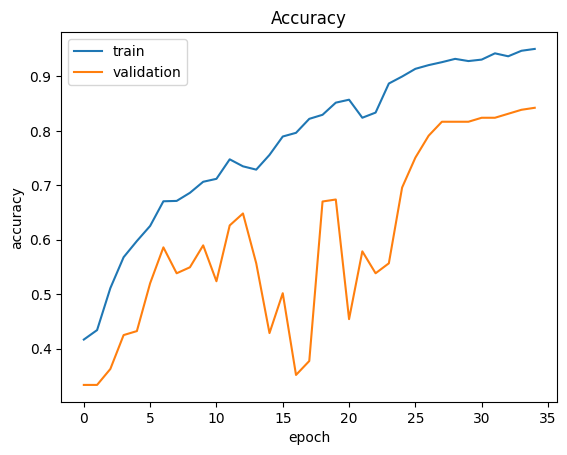

In [35]:
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [72]:
# Evaluating confusion matrix
test_inputs = tf.data.Dataset.from_tensor_slices((test_extr_features, tf.expand_dims(test_images_norm, axis=-1)))
test_labelz = tf.data.Dataset.from_tensor_slices(test_labels)

test_dataset = tf.data.Dataset.zip((test_inputs, test_labelz)).batch(BATCH_SIZE).repeat()
STEP_SIZE_TEST= test_images_norm.shape[0]//BATCH_SIZE

score = model.predict(test_dataset, batch_size=BATCH_SIZE, steps=STEP_SIZE_TEST )


7/7 [==============================] - 25s 4s/step


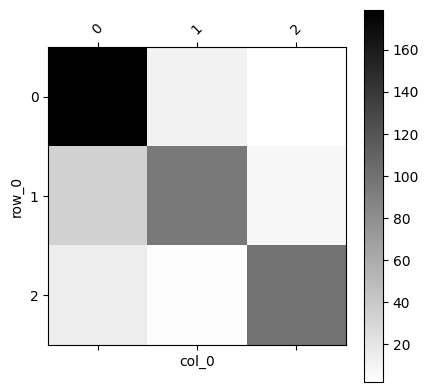

In [76]:
import matplotlib.pyplot as plt
pred = score.round()
test = test_labels[0:448]



def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):
    plt.matshow(df_confusion, cmap=cmap) # imshow
    #plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(df_confusion.columns))
    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
    plt.yticks(tick_marks, df_confusion.index)
    #plt.tight_layout()
    plt.ylabel(df_confusion.index.name)
    plt.xlabel(df_confusion.columns.name)

pred = np.argmax(pred, axis=-1)
test = np.argmax(test, axis=-1)
df_confusion = pd.crosstab(test, pred)
plot_confusion_matrix(df_confusion)